# <div style = 'background-color:#50474E'> <center><font color='#F2DD6C'>Detección de Anomalías en Transacciones Bancarias con Isolation Forest</div><div style = 'background-color:#50474E'> <center>.<font color='#F2DD6C'></div>

#### Indice

<div class="alert alert-block alert-info" style="margin-top: 20px">

1.  [Preparación y limpieza de los datos](#0)<br>
2.  [Analisis exploratorio de los datos](#1)<br>
3.  [Modelado y evaluación](#2) <br>
4.  [Concluciones](#3) <br>

</div>

## <div style = 'background-color:#50474E'> <center><font color='white'>① Preparación y limpieza de los datos </font></div> <a id="0"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore', category=FutureWarning) # Filtrar mensajes de error de versiones.

In [2]:
df = pd.read_csv("bank_transactions_data_2.csv")

In [3]:
df.sample(3)

,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate
1000,TX001001,AC00345,16.73,2023-02-22 17:39:54,Debit,Houston,D000411,27.215.118.94,M073,Online,45,Engineer,48,1,2202.62,2024-11-04 08:09:36
2007,TX002008,AC00352,325.98,2023-07-20 16:58:39,Debit,Washington,D000232,141.241.241.128,M086,ATM,19,Student,277,1,782.35,2024-11-04 08:08:23
2326,TX002327,AC00146,35.98,2023-08-17 16:14:47,Credit,Nashville,D000662,216.31.34.238,M004,Branch,40,Doctor,133,1,11147.34,2024-11-04 08:06:59


Los campos de datos son los siguientes:

- **TransactionID (ID de Transacción):** Identificador alfanumérico único para cada operación.
- **AccountID (ID de Cuenta):** Identificador único de la cuenta.
- **TransactionAmount (Monto de la Transacción):** Valor monetario involucrado en la operación.
- **TransactionDate (Fecha y Hora de la Transacción):** Marca de tiempo de la operación.
- **TransactionType (Tipo de Transacción):** Indica si la transacción es "Crédito" o "Débito".
- **Location (Ubicación):** Localización geográfica (ciudades de EE. UU.).
- **DeviceID (ID de Dispositivo):** Identificador del dispositivo utilizado.
- **IP Address (Dirección IP):** Dirección de red asociada a la transacción.
- **MerchantID (ID de Comercio/Proveedor):** Identificador único del comercio.
- **AccountBalance (Saldo de la Cuenta):** Saldo disponible luego de la transacción.
- **PreviousTransactionDate (Fecha de Transacción Anterior):** Marca de tiempo de la operación previa.
- **Channel (Canal):** Medio por el cual se efectuó (Online, ATM, Sucursal).
- **CustomerAge (Edad del Cliente):** Edad del titular de la cuenta.
- **CustomerOccupation (Ocupación del Cliente):** Ocupación declarada del cliente.
- **TransactionDuration (Duración de la Transacción):** Tiempo en segundos que tomó completarse.
- **LoginAttempts (Intentos de Inicio de Sesión):** Cantidad de intentos fallidos previos al acceso.

Debido a la ausencia de etiquetas predefinidas que identifiquen transacciones fraudulentas el análisis debe realizarse mediante técnicas de aprendizaje no supervisado. En este caso particular implemento el modelo Isolation Forest (Bosques de aislamiento), un algoritmo especializado en detectar anomalías y comportamientos atípicos en conjuntos de datos sin etiquetar.

In [4]:
# Cambio el nombre de las columnas.
df.columns = ['ID_Trans', 'ID_Cuenta', 'Monto', 'Fecha', 'Tipo', 'Ubicacion', 'ID_Disposit', 'Direccion_IP', 'ID_Comercio', 'Canal', 'Edad_Cliente', 'Ocupacion', 'Duracion', 'Intentos_Login', 'Saldo', 'Fecha_Trans_Ant']

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ID_Trans         2512 non-null   object 
 1   ID_Cuenta        2512 non-null   object 
 2   Monto            2512 non-null   float64
 3   Fecha            2512 non-null   object 
 4   Tipo             2512 non-null   object 
 5   Ubicacion        2512 non-null   object 
 6   ID_Disposit      2512 non-null   object 
 7   Direccion_IP     2512 non-null   object 
 8   ID_Comercio      2512 non-null   object 
 9   Canal            2512 non-null   object 
 10  Edad_Cliente     2512 non-null   int64  
 11  Ocupacion        2512 non-null   object 
 12  Duracion         2512 non-null   int64  
 13  Intentos_Login   2512 non-null   int64  
 14  Saldo            2512 non-null   float64
 15  Fecha_Trans_Ant  2512 non-null   object 
dtypes: float64(2), int64(3), object(11)
memory usage: 314.1+ KB


In [6]:
df.duplicated().sum() # Mostrar número de filas duplicadas.

0

In [7]:
df.sample(3)

,ID_Trans,ID_Cuenta,Monto,Fecha,Tipo,Ubicacion,ID_Disposit,Direccion_IP,ID_Comercio,Canal,Edad_Cliente,Ocupacion,Duracion,Intentos_Login,Saldo,Fecha_Trans_Ant
386,TX000387,AC00322,74.42,2023-11-23 17:23:16,Debit,El Paso,D000273,76.136.92.235,M003,Online,49,Engineer,68,1,6264.21,2024-11-04 08:11:23
807,TX000808,AC00316,668.67,2023-11-07 17:38:05,Debit,Detroit,D000682,184.59.28.72,M019,Online,44,Doctor,143,4,13446.81,2024-11-04 08:06:29
238,TX000239,AC00394,33.06,2023-01-17 16:03:41,Credit,Fort Worth,D000417,63.67.150.226,M045,Online,53,Retired,170,1,1540.87,2024-11-04 08:06:43


## <div style = 'background-color:black'> <center><font color='white'>② Analisis exploratorio de los datos (EDA) </font></div><a id="1"></a>

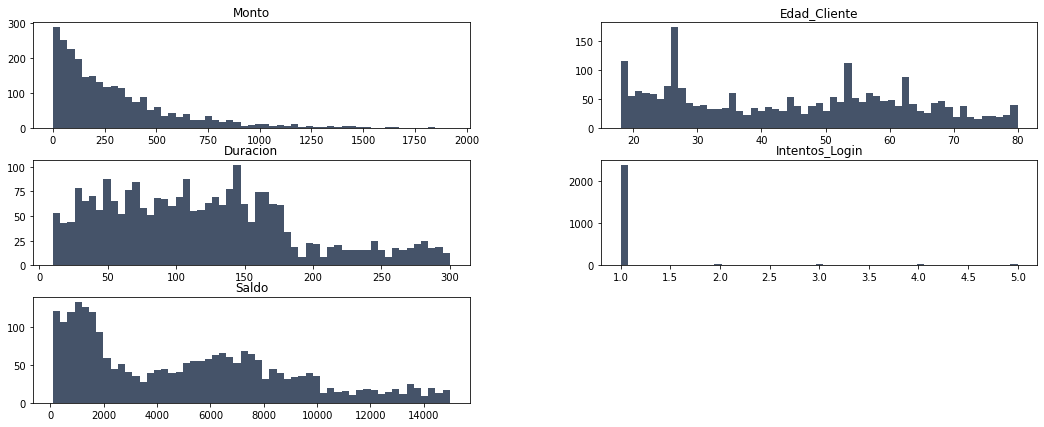

In [8]:
_= df.hist(grid=False, figsize=[18,7], color='#455369', bins=55)

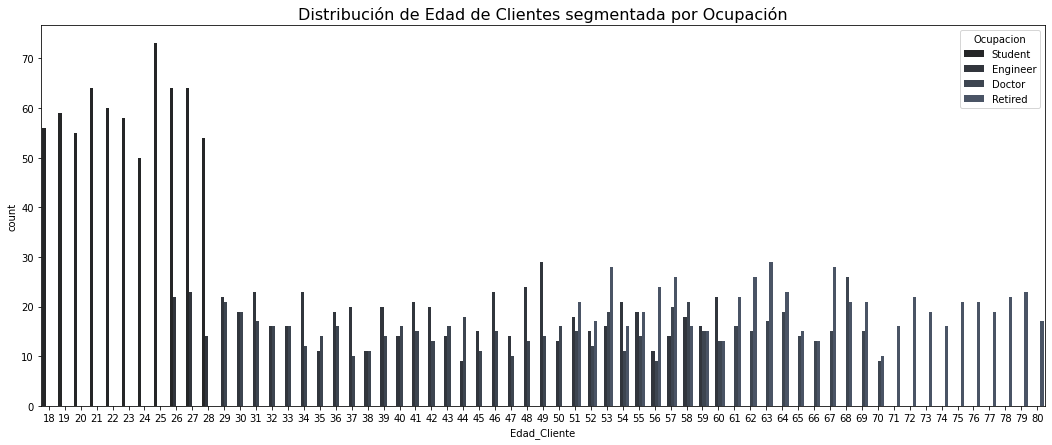

In [9]:
plt.figure(figsize=[18, 7])
sns.countplot(data=df, x='Edad_Cliente', hue='Ocupacion', color='#455369')
plt.title('Distribución de Edad de Clientes segmentada por Ocupación', 
          fontsize=16)
plt.show()

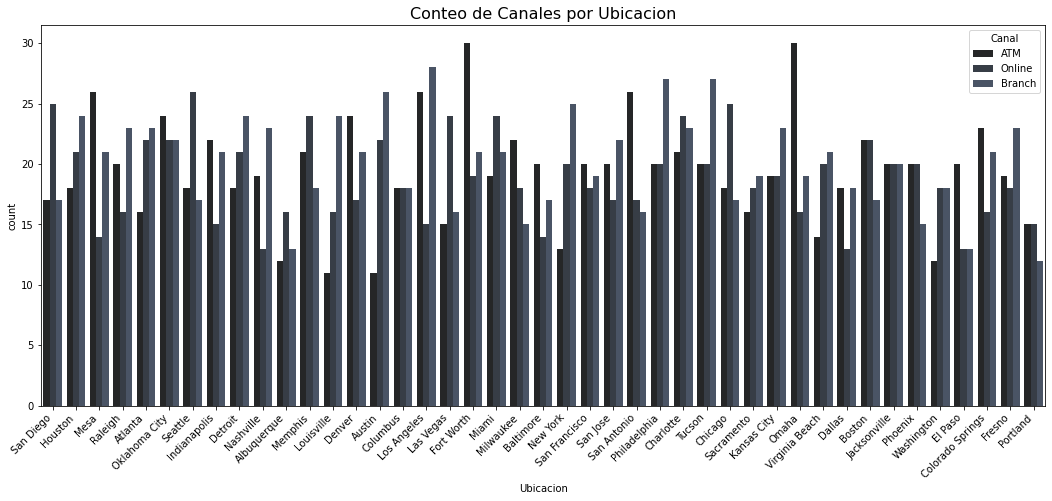

In [10]:
plt.figure(figsize=[18, 7])
sns.countplot(data=df, x='Ubicacion', hue='Canal', color='#455369', orient='v')
plt.title('Conteo de Canales por Ubicacion', 
          fontsize=16)
plt.xticks(rotation=45, ha='right')
plt.show()

#### Procesamiento de datos:

Comienzo a reemplazar los valores de los campos por variables numericas. En el primer caso, el campo 'Tipo' al ser posible dos unicos valores codifico asignando a uno de los posibles valores 0 y 1 al otro. 
Luego con el campo 'Canal' hago lo mismo asignando 0, 1 y 2 como variables.

In [11]:
df['Tipo'].value_counts()

Tipo
Debit     1944
Credit     568
Name: count, dtype: int64

In [12]:
df['Tipo'] = df['Tipo'].replace({
    'Debit': 0,
    'Credit': 1,})

In [13]:
df['Canal'].value_counts()

Canal
Branch    868
ATM       833
Online    811
Name: count, dtype: int64

In [14]:
df['Canal'] = df['Canal'].replace({
    'Branch': 0,
    'ATM': 1,
    'Online': 2})

En el campo ubicación ya tiene muchos resultados posibles y una mala codificación podria generar otras tantas columnas, entonces utilizo una codificacion por frecuencia y modifico el mismo campo sin crear nuevas columnas.

In [15]:
df['Ubicacion'].value_counts().head(5) # Muestro solo los 7 mas frecuentes para no mostrar una fila con muchos valores.

Ubicacion
Fort Worth       70
Los Angeles      69
Oklahoma City    68
Charlotte        68
Tucson           67
Name: count, dtype: int64

In [16]:
# Codificación por Frecuencia, para no generar tantas columnas.
frecuencia_Ub = df['Ubicacion'].value_counts()
df['Ubicacion'] = df['Ubicacion'].map(frecuencia_Ub)

En el caso del campo 'Fecha' aplico un timestamp numérico que convierte una fecha completa a un entero, ese número representa cuántos segundos pasaron desde una fecha base estándar (generalmente es 1 de enero de 1970) El resultado final es un entero grande que expresa tiempo absoluto.

In [17]:
df['Fecha'] = pd.to_datetime(df['Fecha']) # Convierte el campo desde un string a datetime de pandas.
df['Fecha_ts'] = df['Fecha'].astype('int64') // 1e9 # Convierte a int64 dando la cantidad de nanosegundos desde 01/01/1970 luego divide por 1e9 para dejarlo en segundos.

In [18]:
# Tambien creo nuevas columnas extrayendo valores del campo fecha
df['año'] = df['Fecha'].dt.year
df['mes'] = df['Fecha'].dt.month
df['dia'] = df['Fecha'].dt.day
df['hora'] = df['Fecha'].dt.hour
df['minuto'] = df['Fecha'].dt.minute

In [19]:
df = df.drop('Fecha', axis=1) # Borro la columna fecha puesto que ya cree nuevas numericas para tal fin.

Los siguientes campos ID_Disposit, Direccion_IP, ID_Comercio y Fecha_Trans_Ant viendo su composición decido incluirlos en el analisis, para esto debo convertirlos a valores numericos usando tambien en este caso codificación por frecuencia.

In [20]:
df['ID_Disposit'].value_counts().head(5)

ID_Disposit
D000697    9
D000203    9
D000548    9
D000663    9
D000142    9
Name: count, dtype: int64

In [21]:
freq = df['ID_Disposit'].value_counts()
df['ID_Disposit'] = df['ID_Disposit'].map(freq)

In [22]:
df['Direccion_IP'].value_counts().head(5)

Direccion_IP
200.136.146.93    13
49.31.186.82      11
166.79.195.157    10
9.230.41.239      10
173.135.78.201    10
Name: count, dtype: int64

In [23]:
freq = df['Direccion_IP'].value_counts()
df['Direccion_IP'] = df['Direccion_IP'].map(freq)

In [24]:
df['ID_Comercio'].value_counts().head(5) # Tambien solo muestro los 5 mas frecuentes.

ID_Comercio
M026    45
M066    34
M065    33
M013    33
M014    33
Name: count, dtype: int64

In [25]:
freq = df['ID_Comercio'].value_counts()
df['ID_Comercio'] = df['ID_Comercio'].map(freq)

In [26]:
df['Fecha_Trans_Ant'] = pd.to_datetime(df['Fecha_Trans_Ant'])
df['Fecha_Trans_Ant'] = df['Fecha_Trans_Ant'].astype('int64') // 1e9

El campo ocupación tambien convertido a valores numericos asignando valores de 0 a 3.

In [27]:
df['Ocupacion'].value_counts()

Ocupacion
Student     657
Doctor      631
Engineer    625
Retired     599
Name: count, dtype: int64

In [28]:
df['Ocupacion'] = df['Ocupacion'].replace({
    'Student': 0,
    'Doctor': 1,
    'Engineer': 2,
    'Retired': 3})

In [29]:
# Borrado de columnas que no se utilizaran.
df = df.drop(['ID_Trans'], axis=1)
df = df.drop(['ID_Cuenta'], axis=1)

In [30]:
df.sample(3) # Para ver como van quedando los datos convertidos a valores numericos.

,Monto,Tipo,Ubicacion,ID_Disposit,Direccion_IP,ID_Comercio,Canal,Edad_Cliente,Ocupacion,Duracion,Intentos_Login,Saldo,Fecha_Trans_Ant,Fecha_ts,año,mes,dia,hora,minuto
91,223.85,0,61,4,3,30,1,53,2,55,4,2929.91,1.730708e+09,1.696265e+09,2023,10,2,16,36
302,61.43,0,55,3,4,22,2,24,0,170,1,1882.77,1.730708e+09,1.688055e+09,2023,6,29,16,16
1199,161.31,0,55,4,6,23,1,28,0,13,1,1268.67,1.730708e+09,1.694449e+09,2023,9,11,16,24


#### Creacion de nuevas caracteristicas con los datos:

Creo nueva columna donde para cada fila veo cuánto representa el Monto respecto del Saldo disponible. (El +1 es para evitar errores cuando el saldo es igual a 0). Si el valor es alto (ej: 2, 5, 10) significa que el monto de la transacción es mucho mayor que el saldo. Si el valor está cerca de 1 el monto es parecido al saldo y si el valor es menor a 1 quiere decir que el monto es más chico que el saldo. Cuando un monto supera el saldo disponible suelen ser operaciones menos comunes y a veces están asociadas a un comportamiento irregular.

In [31]:
df['monto_vs_saldo'] = df['Monto'] / (df['Saldo'] + 1) 

Esta nueva caracteristica, mide cuántas ubicaciones distintas usa cada dispositivo. La nueva columna identifica cuantas ubicaciones diferentes utilizo ese dispositivo en todo el historial, para analizar que un dispositivo que siempre opera desde una sola ubicación puede ser normal en cambio un dispositivo que aparece con muchas ubicaciones distintas puede indicar uso compartido, posible robo de credenciales, comportamiento inusual.

In [32]:
# Agrupo por ID_Disposit, dentro de cada grupo calcula el numero de ubicaciones unicas (nunique) usadas por ese dispositivo
df['ubicaciones_distintas'] = df.groupby('ID_Disposit')['Ubicacion'].transform('nunique')

La proxima nueva caracteristica, suma cuántas veces aparece una dirección IP en el historial del dispositivo. En definitiva muestra cuantas transacciones (o registros) tiene ese dispositivo en total.

In [33]:
# Agrupo por ID_Disposit, dentro de cada grupo calculo la direccion de IP 
df['IP.Freqxcliente'] = df.groupby('ID_Disposit')['Direccion_IP'].transform('count')

Un dispositivo que cambia IP muy seguido suele ser sospechoso, puede indicar VPN, proxys, movimientos fuera del patrón habitual o un acceso no autorizado. El primer registro de cada dispositivo siempre marca 1 (no hay historial anterior), lo cual es normal: dispositivos nuevos también representan mayor riesgo. En resumen indica si el dispositivo está usando una IP diferente de la inmediatamente anterior.

In [34]:
Cormat = df.corr()

<AxesSubplot:>

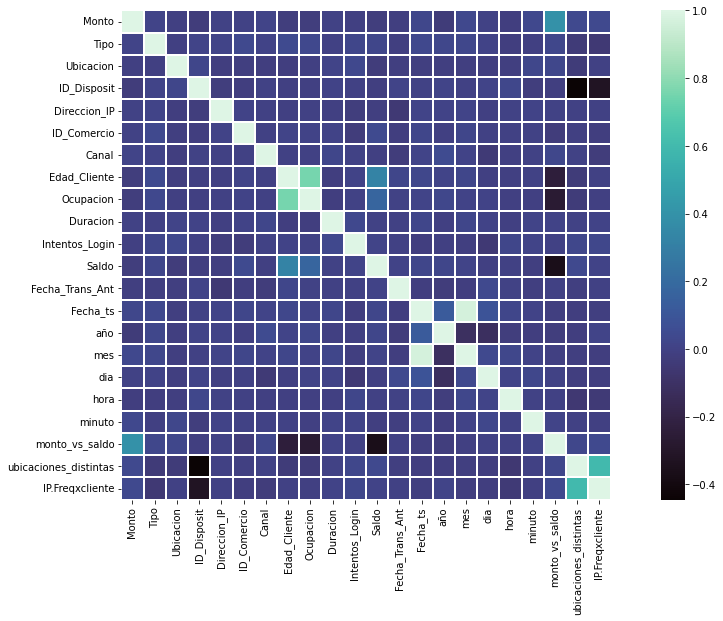

In [35]:
f, ax = plt.subplots(figsize=(18,9))
sns.heatmap(Cormat, vmax=1, square=True, cmap="mako", annot=False, linewidths=.1)

## <div style = 'background-color:Black'> <center><font color='white'>③ Modelado y evaluación </font></div><a id="2"></a>

Isolation forest no es modelo supervisado, no lleva variable objetivo "y", no requiere division de datos de entrenamiento y test, puesto que no hay una verdad conocida para comparar o que guie el proceso de aprendizaje. Entonces la información proviene unicamente de X que son las variables disponibles.

In [36]:
from sklearn.ensemble import IsolationForest

In [37]:
# Defino solo X.
data = df
X = data 

In [38]:
model = IsolationForest(n_estimators=100,
                        contamination=0.0362, # 3.62% de los datos se consideran anomalías
                        random_state=42)

In [39]:
model.fit(X) # Entrenar el modelo, solicitando que aprenda como es el comportamiento habitual de estas observaciones.

IsolationForest(contamination=0.0362, random_state=42)

In [40]:
features = X.columns # Guardo los nombres exactos de las columnas que usa el modelo.

In [41]:
X_original = df[features] # Utilizar el DF original (codigo para evitar error posterior)

In [42]:
y_pred = model.predict(X) # Clasifica cada fila como Inlier (1) u Outlier-anomalo (-1).

scores = model.decision_function(X) # Da la puntuación de anomalia, valores (-0) anomalos, cercanos a 0 sospechosos y mayores seran normales

In [43]:
df[df.columns[-6:]].sample(3) # Veo una muestra de las ultimas 6 columnas del DF

,dia,hora,minuto,monto_vs_saldo,ubicaciones_distintas,IP.Freqxcliente
1872,9,16,21,0.601784,22,336
1398,8,17,42,0.020479,19,120
2152,28,16,30,0.027187,22,435


In [44]:
scores

array([0.11994791, 0.10745434, 0.10302279, ..., 0.12074295, 0.07879802,
       0.04642963])

El modelo no conoce cuántos fraudes existen realmente en los datos, por lo tanto es necesario indicarle una estimación aproximada mediante el parámetro contamination.
Si se disponen de etiquetas, ese porcentaje puede calcularse directamente; pero cuando no se tienen, se recurre a un valor heurístico (según la experiencia y conocimiento del problema) basado en la frecuencia típica del fraude.

Valores típicos en fraude:

- 0.01 (1%) — cuando el fraude es muy raro
- 0.02–0.05 — para datasets con ruido o fraude moderado
- 0.10 — cuando se quiere ser agresivo (generando mas alertas)

Otra opción es ver el histograma de Scores obtenido y hacer un analisis del umbral. Que es ver dónde está el valle o caída brusca del histograma, qué tan lejos están los valores más negativos y qué porcentaje de puntos queda por debajo del umbral.

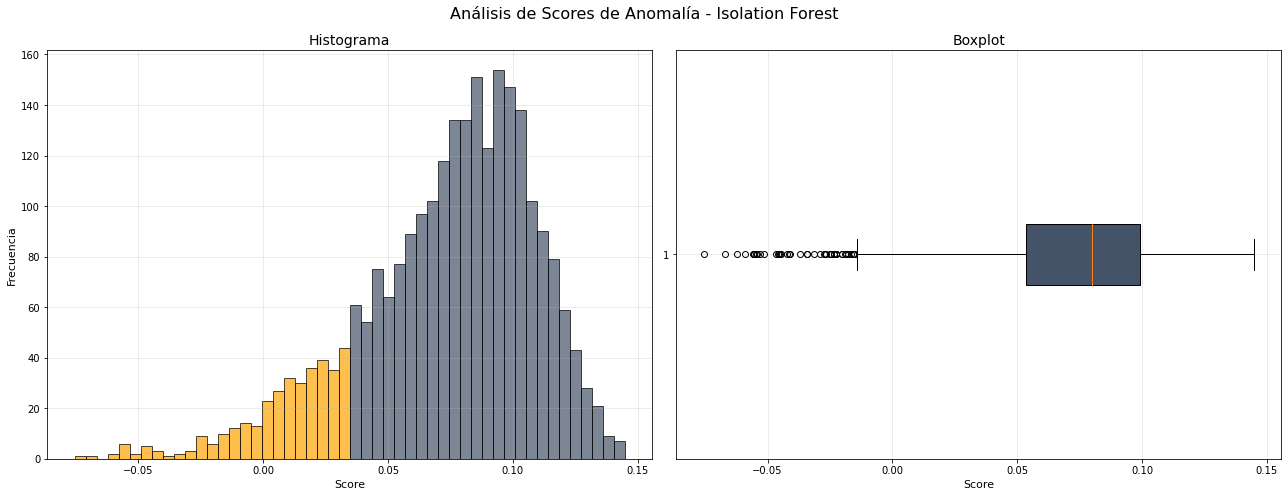

In [45]:
umbral = 0.0362

fig, axes = plt.subplots(1, 2, figsize=(18, 7))  # Código para crear una sola figura con 2 subplots

# Histograma
n, bins, patches = axes[0].hist(scores, bins=50, 
                                color='#455369', edgecolor='black', alpha=0.7)

# Codigo para pintar de naranja las barras menores al umbral
for i in range(len(bins) - 1):
    if bins[i+1] <= umbral:          # si la barra está por debajo del umbral
        patches[i].set_facecolor('orange')
    else:
        patches[i].set_facecolor('#455369')

axes[0].set_title('Histograma', fontsize=14)
axes[0].set_xlabel('Score', fontsize=11)
axes[0].set_ylabel('Frecuencia', fontsize=11)
axes[0].grid(True, alpha=0.3)

# Diagrama de caja
axes[1].boxplot(scores, vert=False, patch_artist=True, 
                boxprops=dict(facecolor='#455369'))
axes[1].set_title('Boxplot', fontsize=14)
axes[1].set_xlabel('Score', fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.suptitle('Análisis de Scores de Anomalía - Isolation Forest', fontsize=16)
plt.tight_layout()
plt.show()


<div class="alert alert-warning">En el histograma de la izquierda no se busca el punto más bajo absoluto o con menor frecuencia si no el punto de inflexión donde la dispersión de anomalias deja de ser una region de baja densidad y empieza a mostrar el aumento sostenido que define el bloque de los datos normales, es el punto donde cambia la pendiente de un plano casi horizontal a una subida pronunciada. La parte de la izquierda de naranja (donde son scores negativos o menores) tiene fluctuaciones pequeñas, barras pequeñas que suben y bajan con pequeña variabilidad entre si, pero toda esa zona sigue siendo de baja densidad.

La parte derecha del histograma (donde ahora los scores son positivos) tiene un aumento marcado y sostenido que forma el bloque mas denso de los valores normales (inliers) comienza aproximadamente en X=0,362.

El valle de separación que definirá la contaminación, no es necesariamente donde la barra es más baja en el histograma, si no mas bien es donde termina la región dispersa y empieza la región mas densa. 

Por otro lado a la derecha en el grafico de caja, se puede ver la dispersión de la variable "scores" los outliers que identifica y donde estan los cuartiles 1 y 3 que representan el 50% de los valores (entre 0,05 y 0,10).</div>



In [46]:
df['score'] = scores
df.sort_values('score').head(25)  # los 25 datos con scores más bajos.

,Monto,Tipo,Ubicacion,ID_Disposit,Direccion_IP,ID_Comercio,Canal,Edad_Cliente,Ocupacion,Duracion,...,Fecha_ts,año,mes,dia,hora,minuto,monto_vs_saldo,ubicaciones_distintas,IP.Freqxcliente,score
1616,34.74,1,42,9,5,19,2,59,3,72,...,1.682698e+09,2023,4,28,16,3,0.009295,17,63,-0.075481
2124,737.46,1,41,7,3,23,0,53,1,75,...,1.672763e+09,2023,1,3,16,28,1.161062,22,217,-0.066888
1375,221.49,1,68,9,6,27,0,23,0,196,...,1.694629e+09,2023,9,13,18,11,0.312729,17,63,-0.062256
1491,506.26,1,51,8,13,33,1,64,3,86,...,1.702924e+09,2023,12,18,18,26,0.080773,19,120,-0.059250
898,1531.31,0,59,3,8,25,2,18,0,62,...,1.698084e+09,2023,10,23,18,0,1.778814,22,435,-0.055984
229,630.24,0,61,9,3,27,1,21,0,62,...,1.701281e+09,2023,11,29,18,10,1.695059,17,63,-0.055608
625,821.54,1,61,9,2,24,0,79,3,36,...,1.692728e+09,2023,8,22,18,11,0.203285,17,63,-0.055588
151,332.93,1,41,9,6,25,0,35,2,293,...,1.700498e+09,2023,11,20,16,29,0.119364,17,63,-0.055578
1635,40.12,1,49,9,5,22,1,36,1,269,...,1.681924e+09,2023,4,19,17,3,0.002805,17,63,-0.054721
274,1176.28,1,61,4,4,27,1,54,2,174,...,1.703088e+09,2023,12,20,16,8,3.622779,22,596,-0.054422


In [47]:
df['anomalia'] = model.predict(X_original) # Agrego una nueva columna, se evalua cada fila y devuelve -1 si es anomalia o 1 si es normal.
df['score'] = model.decision_function(X_original) # Agrego otra columna, guarda el puntaje de anomalía que usa el modelo internamente para tomar su decisión.

In [48]:
perfil = df.groupby('anomalia').mean()
perfil

,Monto,Tipo,Ubicacion,ID_Disposit,Direccion_IP,ID_Comercio,Canal,Edad_Cliente,Ocupacion,Duracion,...,Fecha_ts,año,mes,dia,hora,minuto,monto_vs_saldo,ubicaciones_distintas,IP.Freqxcliente,score
anomalia,,,,,,,,,,,,,,,,,,,,,
-1,359.196923,0.461538,57.560440,6.637363,5.142857,26.802198,0.846154,45.494505,1.373626,118.747253,...,1.690417e+09,2023.021978,7.021978,16.802198,16.978022,28.263736,0.490459,18.835165,144.439560,-0.022230
1,295.278253,0.217266,59.242462,4.489880,5.159025,26.106154,0.982239,44.643123,1.467575,119.676993,...,1.688520e+09,2023.004544,6.545229,15.790582,16.612970,29.522924,0.188546,21.780669,396.821148,0.077089


| **Característica**       | **Media Anomalía (-1)** | **Media Normal (1)** | **Interpretación** |
|--------------------------|--------------------------|------------------------|----------------------|
| **Monto**                | 359.19                   | 295.27                 | Las anomalías tienen un monto promedio significativamente más alto (+21%). El modelo señala transacciones caras como anómalas. |
| **monto_vs_saldo**       | 0.490                    | 0.188                  | Las anomalías consumen un porcentaje del saldo mucho mayor (2.6×). Es un indicador muy fuerte de riesgo. |
| **IP.Freqxcliente**      | 144.43                   | 396.82                 | Las anomalías provienen de combinaciones IP/Cliente con poca frecuencia. Menor uso: Comportamiento atípico o nueva IP. |
| **Tipo** / **Canal**     | 0.461 / 0.846            | 0.217 / 0.982          | Las anomalías usan un Tipo más alto (categoría menos común) y un Canal menos habitual. |
| **ID_Disposit**          | 6.63                     | 4.48                   | Las anomalías usan dispositivos menos comunes o mayor diversidad de dispositivos. |


<div class="alert alert-warning">Como conclusión parcial: El modelo ha aprendido a clasificar como anómala cada transacción con un monto alto, que consume gran parte del saldo, que sea realizada desde un dispositivo/IP poco frecuente y que utiliza un tipo o canal de transacción atípico.</div>

In [49]:
# Ordenar por score (los más negativos primero)
top_anomalias = df[df['anomalia'] == -1].sort_values(by='score', ascending=True).head(10)
top_anomalias

,Monto,Tipo,Ubicacion,ID_Disposit,Direccion_IP,ID_Comercio,Canal,Edad_Cliente,Ocupacion,Duracion,...,año,mes,dia,hora,minuto,monto_vs_saldo,ubicaciones_distintas,IP.Freqxcliente,score,anomalia
1616,34.74,1,42,9,5,19,2,59,3,72,...,2023,4,28,16,3,0.009295,17,63,-0.075481,-1
2124,737.46,1,41,7,3,23,0,53,1,75,...,2023,1,3,16,28,1.161062,22,217,-0.066888,-1
1375,221.49,1,68,9,6,27,0,23,0,196,...,2023,9,13,18,11,0.312729,17,63,-0.062256,-1
1491,506.26,1,51,8,13,33,1,64,3,86,...,2023,12,18,18,26,0.080773,19,120,-0.059250,-1
898,1531.31,0,59,3,8,25,2,18,0,62,...,2023,10,23,18,0,1.778814,22,435,-0.055984,-1
229,630.24,0,61,9,3,27,1,21,0,62,...,2023,11,29,18,10,1.695059,17,63,-0.055608,-1
625,821.54,1,61,9,2,24,0,79,3,36,...,2023,8,22,18,11,0.203285,17,63,-0.055588,-1
151,332.93,1,41,9,6,25,0,35,2,293,...,2023,11,20,16,29,0.119364,17,63,-0.055578,-1
1635,40.12,1,49,9,5,22,1,36,1,269,...,2023,4,19,17,3,0.002805,17,63,-0.054721,-1
274,1176.28,1,61,4,4,27,1,54,2,174,...,2023,12,20,16,8,3.622779,22,596,-0.054422,-1


<div class="alert alert-warning">Este listado reúne las transacciones con los puntajes más negativos. Si, al revisarlas, la mayoría son identificadas por un especialista en fraudes o por uno mismo como verdaderas anomalías (fraudes, errores o movimientos atípicos), entonces el modelo está cumpliendo correctamente su función.</div>

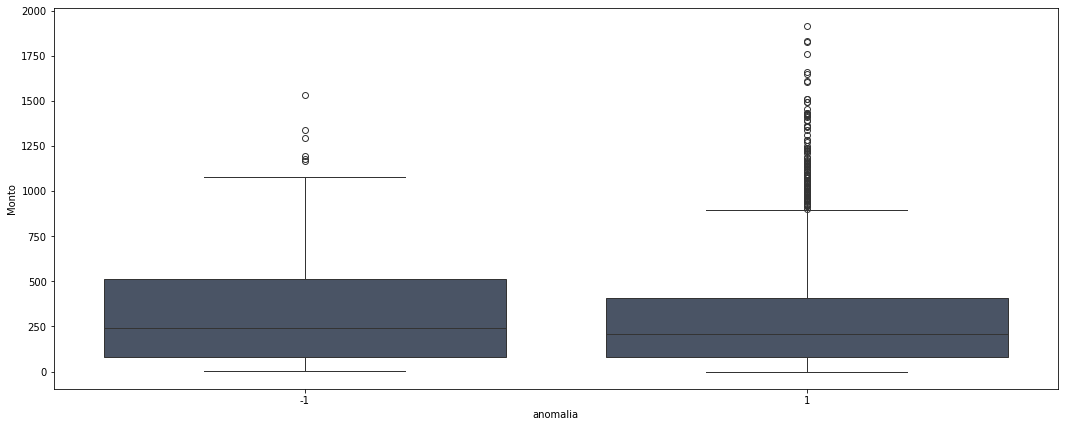

In [50]:
import seaborn as sns
plt.figure(figsize=(18, 7))
sns.boxplot(data=df, x='anomalia', y='Monto', color='#455369')
plt.show()

<div class="alert alert-warning">En el gráfico se analiza la distribución de la variable Monto en función del campo “anomalia”, con el objetivo de observar cómo se comportan los importes entre las transacciones clasificadas como normales y aquellas identificadas como anómalas por el modelo.

El grupo -1 (anómalo) presenta una mediana de monto un poco más alta. Un rango intercuartílico desplazado hacia valores mayores tambien respecto al otro conjunto de datos. Tambien sus bigotes sobretodo el superior presenta una distribución más extendida, indicando una variabilidad mas alta.
Aqui todo indica que el modelo de Isolation Forest aplicado detecta anomalías por otras variables y no solo porque el monto sea o no grande.

Las transacciones grandes no siempre son anómalas, en el grafico de la derecha pueden verse que algunos montos enormes quedan clasificados como normales. Las anomalías aparecen también en montos intermedios.</div>



---
✍️ Autor: Néstor Díaz — Contador Público | Analista de Datos | Machine Learning

📅 Proyecto: Análisis crediticio y gestión del riesgo de crédito

---